In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [2]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support
    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174701-Cranium_merged_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [3]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [3]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [4]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [5]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [4]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape)

def get_bounding_box_data(inputMeshPoints):
    ElementIdentifierType = itk.UL
    CoordType = itk.F
    Dimension = 3

    VecContType = itk.VectorContainer[
        ElementIdentifierType, itk.Point[CoordType, Dimension]
    ]

    ps = itk.PointSet.D3.New()
    ps.SetPoints(itk.vector_container_from_array(inputMeshPoints.flatten()))

    bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
    bounding_box.SetPoints(ps.GetPoints())
    bounding_box.ComputeBoundingBox()

    minBounds = np.array(bounding_box.GetMinimum())
    maxBounds = np.array(bounding_box.GetMaximum())
    
    return maxBounds - minBounds, bounding_box.GetCenter()

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
w1.SetFileName('movingMeshScaled.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(scaledMovingMesh)
w1.Update()

(8002, 3)
(3754, 3) 2209640


In [47]:
# movingMeshPath = 'movingMeshScaled.vtk'
# fixedMeshPath = 'fixedMesh.vtk'

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[fixedMesh, movingMesh])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [49]:
# For performing RANSAC in parallel
#%%timeit

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk

def final_iteration(fixedPoints, movingPoints, transform_type):
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]
    else:
        TransformType = itk.AffineTransform[itk.D, 3]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_fixed)
    metric.SetFixedPointSet(mesh_moving)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())    
    number_of_epochs = 10000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())
    
    current_transform = metric.GetTransform()
    itk_transformed_mesh = itk.transform_mesh_filter(
        mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints())

def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            # works best
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            # does not work well
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            # works ok
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()
        
        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

#         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
#         optimizer.SetNumberOfIterations(200)
#         optimizer.SetLearningRate(0.0001)
#         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
#         optimizer.SetMinimumConvergenceValue( 0.0 )
#         optimizer.SetConvergenceWindowSize( 200 )
#         optimizer.SetMetric(metric)
#         optimizer.StartOptimization()
        
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result

import time

number_of_iterations = 1000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

#movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
#fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape, movingMeshPoints.shape)

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
w1.SetFileName('movingMeshScaled.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(scaledMovingMesh)
w1.Update()

if 1:
    start_time = time.time()
    transform_type = 0
    itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                                 movingMeshAllPoints,
                                                 number_of_iterations,
                                                 mesh_sub_sample_points,
                                                 number_of_ransac_points,
                                                 transform_type, convergence_value)
    end_time = time.time()

    print(end_time - start_time)
    print('itk_transformed_points shape ', itk_transformed_points.shape)
    
    transform_type = 0
    final_mesh = final_iteration(fixedMeshPoints, itk_transformed_points, transform_type)

    newmesh = itk.Mesh.D3.New()
    newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

    w1 = itk.MeshFileWriter[type(newmesh)].New()
    w1.SetFileName('ransacICPResult2_b.vtk')
    w1.SetFileTypeAsBINARY()
    w1.SetInput(newmesh)
    w1.Update()

(8002, 3) (3754, 3)
(2209640, 3) float32
(3754, 3) 2209640
(9.261352755582676, 836)
27.094037771224976
itk_transformed_points shape  (3754, 3)
Initial Value  10.895812712442686
It: 0 metric value: 10.895813 
It: 1 metric value: 10.502788 
It: 2 metric value: 10.406878 
It: 3 metric value: 10.348353 
It: 4 metric value: 10.300549 
It: 5 metric value: 10.257239 
It: 6 metric value: 10.210086 
It: 7 metric value: 10.164424 
It: 8 metric value: 10.119893 
It: 9 metric value: 10.074202 
It: 10 metric value: 10.031795 
It: 11 metric value: 9.988721 
It: 12 metric value: 9.946844 
It: 13 metric value: 9.909834 
It: 14 metric value: 9.877068 
It: 15 metric value: 9.845514 
It: 16 metric value: 9.811981 
It: 17 metric value: 9.779437 
It: 18 metric value: 9.746452 
It: 19 metric value: 9.713655 
It: 20 metric value: 9.678391 
It: 21 metric value: 9.649140 
It: 22 metric value: 9.623456 
It: 23 metric value: 9.599793 
It: 24 metric value: 9.579856 
It: 25 metric value: 9.558826 
It: 26 metric va

It: 275 metric value: 9.094985 
It: 276 metric value: 9.095042 
It: 277 metric value: 9.094707 
It: 278 metric value: 9.094601 
It: 279 metric value: 9.094655 
It: 280 metric value: 9.094811 
It: 281 metric value: 9.094827 
It: 282 metric value: 9.094530 
It: 283 metric value: 9.094841 
It: 284 metric value: 9.094432 
It: 285 metric value: 9.094507 
It: 286 metric value: 9.094839 
It: 287 metric value: 9.094329 
It: 288 metric value: 9.094717 
It: 289 metric value: 9.094644 
It: 290 metric value: 9.094661 
It: 291 metric value: 9.094802 
It: 292 metric value: 9.094265 
It: 293 metric value: 9.094803 
It: 294 metric value: 9.094499 
It: 295 metric value: 9.095023 
It: 296 metric value: 9.094048 
It: 297 metric value: 9.094916 
It: 298 metric value: 9.094239 
It: 299 metric value: 9.094963 
It: 300 metric value: 9.094113 
It: 301 metric value: 9.094586 
It: 302 metric value: 9.094697 
It: 303 metric value: 9.094250 
It: 304 metric value: 9.094644 
It: 305 metric value: 9.094412 
It: 306 

It: 592 metric value: 9.091283 
It: 593 metric value: 9.090909 
It: 594 metric value: 9.090993 
It: 595 metric value: 9.091066 
It: 596 metric value: 9.091127 
It: 597 metric value: 9.091121 
It: 598 metric value: 9.090941 
It: 599 metric value: 9.091305 
It: 600 metric value: 9.090788 
It: 601 metric value: 9.090940 
It: 602 metric value: 9.090830 
It: 603 metric value: 9.091059 
It: 604 metric value: 9.090536 
It: 605 metric value: 9.090945 
It: 606 metric value: 9.090797 
It: 607 metric value: 9.091039 
It: 608 metric value: 9.090468 
It: 609 metric value: 9.090834 
It: 610 metric value: 9.090963 
It: 611 metric value: 9.091029 
It: 612 metric value: 9.090436 
It: 613 metric value: 9.090795 
It: 614 metric value: 9.090955 
It: 615 metric value: 9.090997 
It: 616 metric value: 9.090631 
It: 617 metric value: 9.090976 
It: 618 metric value: 9.090574 
It: 619 metric value: 9.090927 
It: 620 metric value: 9.090728 
It: 621 metric value: 9.091018 
It: 622 metric value: 9.090331 
It: 623 

It: 888 metric value: 9.088506 
It: 889 metric value: 9.088635 
It: 890 metric value: 9.088680 
It: 891 metric value: 9.088731 
It: 892 metric value: 9.088526 
It: 893 metric value: 9.088393 
It: 894 metric value: 9.088829 
It: 895 metric value: 9.088495 
It: 896 metric value: 9.089013 
It: 897 metric value: 9.088943 
It: 898 metric value: 9.087754 
It: 899 metric value: 9.088498 
It: 900 metric value: 9.088547 
It: 901 metric value: 9.088770 
It: 902 metric value: 9.088214 
It: 903 metric value: 9.088546 
It: 904 metric value: 9.088429 
It: 905 metric value: 9.088707 
It: 906 metric value: 9.088315 
It: 907 metric value: 9.088653 
It: 908 metric value: 9.088476 
It: 909 metric value: 9.088428 
It: 910 metric value: 9.088459 
It: 911 metric value: 9.088728 
It: 912 metric value: 9.088044 
It: 913 metric value: 9.088329 
It: 914 metric value: 9.088606 
It: 915 metric value: 9.088434 
It: 916 metric value: 9.088438 
It: 917 metric value: 9.088452 
It: 918 metric value: 9.088352 
It: 919 

It: 1194 metric value: 9.086362 
It: 1195 metric value: 9.086034 
It: 1196 metric value: 9.087122 
It: 1197 metric value: 9.087734 
It: 1198 metric value: 9.088558 
It: 1199 metric value: 9.089243 
It: 1200 metric value: 9.089764 
It: 1201 metric value: 9.088989 
It: 1202 metric value: 9.089705 
It: 1203 metric value: 9.089094 
It: 1204 metric value: 9.089914 
It: 1205 metric value: 9.088624 
It: 1206 metric value: 9.089190 
It: 1207 metric value: 9.089370 
It: 1208 metric value: 9.089177 
It: 1209 metric value: 9.089354 
It: 1210 metric value: 9.089132 
It: 1211 metric value: 9.089438 
It: 1212 metric value: 9.089438 
It: 1213 metric value: 9.089593 
It: 1214 metric value: 9.089171 
It: 1215 metric value: 9.089698 
It: 1216 metric value: 9.088736 
It: 1217 metric value: 9.089334 
It: 1218 metric value: 9.089460 
It: 1219 metric value: 9.089182 
It: 1220 metric value: 9.089578 
It: 1221 metric value: 9.088771 
It: 1222 metric value: 9.089842 
It: 1223 metric value: 9.088536 
It: 1224 m

It: 1490 metric value: 9.087174 
It: 1491 metric value: 9.087079 
It: 1492 metric value: 9.087020 
It: 1493 metric value: 9.086891 
It: 1494 metric value: 9.087360 
It: 1495 metric value: 9.086602 
It: 1496 metric value: 9.087328 
It: 1497 metric value: 9.086500 
It: 1498 metric value: 9.087892 
It: 1499 metric value: 9.085642 
It: 1500 metric value: 9.086529 
It: 1501 metric value: 9.086232 
It: 1502 metric value: 9.087355 
It: 1503 metric value: 9.085941 
It: 1504 metric value: 9.086533 
It: 1505 metric value: 9.086502 
It: 1506 metric value: 9.087575 
It: 1507 metric value: 9.085747 
It: 1508 metric value: 9.086790 
It: 1509 metric value: 9.086665 
It: 1510 metric value: 9.087282 
It: 1511 metric value: 9.085922 
It: 1512 metric value: 9.086811 
It: 1513 metric value: 9.086917 
It: 1514 metric value: 9.087011 
It: 1515 metric value: 9.086388 
It: 1516 metric value: 9.087472 
It: 1517 metric value: 9.085705 
It: 1518 metric value: 9.086520 
It: 1519 metric value: 9.086678 
It: 1520 m

It: 1794 metric value: 9.084610 
It: 1795 metric value: 9.083330 
It: 1796 metric value: 9.084668 
It: 1797 metric value: 9.083563 
It: 1798 metric value: 9.084379 
It: 1799 metric value: 9.082876 
It: 1800 metric value: 9.084127 
It: 1801 metric value: 9.083494 
It: 1802 metric value: 9.084506 
It: 1803 metric value: 9.083368 
It: 1804 metric value: 9.084359 
It: 1805 metric value: 9.082855 
It: 1806 metric value: 9.084038 
It: 1807 metric value: 9.083522 
It: 1808 metric value: 9.084450 
It: 1809 metric value: 9.083346 
It: 1810 metric value: 9.084230 
It: 1811 metric value: 9.082851 
It: 1812 metric value: 9.084116 
It: 1813 metric value: 9.083099 
It: 1814 metric value: 9.084405 
It: 1815 metric value: 9.083192 
It: 1816 metric value: 9.084270 
It: 1817 metric value: 9.082862 
It: 1818 metric value: 9.083846 
It: 1819 metric value: 9.083386 
It: 1820 metric value: 9.083939 
It: 1821 metric value: 9.082973 
It: 1822 metric value: 9.083998 
It: 1823 metric value: 9.083103 
It: 1824 m

It: 2128 metric value: 9.077703 
It: 2129 metric value: 9.079762 
It: 2130 metric value: 9.078674 
It: 2131 metric value: 9.078920 
It: 2132 metric value: 9.078629 
It: 2133 metric value: 9.078912 
It: 2134 metric value: 9.078577 
It: 2135 metric value: 9.078587 
It: 2136 metric value: 9.079185 
It: 2137 metric value: 9.078908 
It: 2138 metric value: 9.078603 
It: 2139 metric value: 9.078689 
It: 2140 metric value: 9.078678 
It: 2141 metric value: 9.078186 
It: 2142 metric value: 9.079144 
It: 2143 metric value: 9.078943 
It: 2144 metric value: 9.078697 
It: 2145 metric value: 9.078983 
It: 2146 metric value: 9.078170 
It: 2147 metric value: 9.079395 
It: 2148 metric value: 9.077658 
It: 2149 metric value: 9.079465 
It: 2150 metric value: 9.078776 
It: 2151 metric value: 9.078349 
It: 2152 metric value: 9.079259 
It: 2153 metric value: 9.078564 
It: 2154 metric value: 9.078686 
It: 2155 metric value: 9.078486 
It: 2156 metric value: 9.078521 
It: 2157 metric value: 9.078697 
It: 2158 m

It: 2439 metric value: 9.076937 
It: 2440 metric value: 9.076298 
It: 2441 metric value: 9.077370 
It: 2442 metric value: 9.076466 
It: 2443 metric value: 9.076981 
It: 2444 metric value: 9.076358 
It: 2445 metric value: 9.076994 
It: 2446 metric value: 9.076157 
It: 2447 metric value: 9.077401 
It: 2448 metric value: 9.077235 
It: 2449 metric value: 9.076203 
It: 2450 metric value: 9.076849 
It: 2451 metric value: 9.076159 
It: 2452 metric value: 9.077297 
It: 2453 metric value: 9.076708 
It: 2454 metric value: 9.076481 
It: 2455 metric value: 9.076115 
It: 2456 metric value: 9.077286 
It: 2457 metric value: 9.076553 
It: 2458 metric value: 9.076644 
It: 2459 metric value: 9.075735 
It: 2460 metric value: 9.076762 
It: 2461 metric value: 9.076461 
It: 2462 metric value: 9.076964 
It: 2463 metric value: 9.077360 
It: 2464 metric value: 9.076014 
It: 2465 metric value: 9.076581 
It: 2466 metric value: 9.076217 
It: 2467 metric value: 9.076348 
It: 2468 metric value: 9.076179 
It: 2469 m

It: 2768 metric value: 9.074089 
It: 2769 metric value: 9.074304 
It: 2770 metric value: 9.074515 
It: 2771 metric value: 9.073659 
It: 2772 metric value: 9.074118 
It: 2773 metric value: 9.074271 
It: 2774 metric value: 9.074172 
It: 2775 metric value: 9.074298 
It: 2776 metric value: 9.074003 
It: 2777 metric value: 9.074498 
It: 2778 metric value: 9.073529 
It: 2779 metric value: 9.074249 
It: 2780 metric value: 9.073899 
It: 2781 metric value: 9.074300 
It: 2782 metric value: 9.074555 
It: 2783 metric value: 9.073426 
It: 2784 metric value: 9.074377 
It: 2785 metric value: 9.073661 
It: 2786 metric value: 9.073883 
It: 2787 metric value: 9.073499 
It: 2788 metric value: 9.074204 
It: 2789 metric value: 9.074223 
It: 2790 metric value: 9.073871 
It: 2791 metric value: 9.073401 
It: 2792 metric value: 9.074253 
It: 2793 metric value: 9.073870 
It: 2794 metric value: 9.074083 
It: 2795 metric value: 9.073824 
It: 2796 metric value: 9.074181 
It: 2797 metric value: 9.074002 
It: 2798 m

It: 3069 metric value: 9.072417 
It: 3070 metric value: 9.071118 
It: 3071 metric value: 9.072456 
It: 3072 metric value: 9.071263 
It: 3073 metric value: 9.072317 
It: 3074 metric value: 9.071581 
It: 3075 metric value: 9.072269 
It: 3076 metric value: 9.071251 
It: 3077 metric value: 9.072428 
It: 3078 metric value: 9.071015 
It: 3079 metric value: 9.072327 
It: 3080 metric value: 9.071306 
It: 3081 metric value: 9.072208 
It: 3082 metric value: 9.070704 
It: 3083 metric value: 9.072367 
It: 3084 metric value: 9.070861 
It: 3085 metric value: 9.072199 
It: 3086 metric value: 9.070573 
It: 3087 metric value: 9.072513 
It: 3088 metric value: 9.070733 
It: 3089 metric value: 9.072396 
It: 3090 metric value: 9.071070 
It: 3091 metric value: 9.072334 
It: 3092 metric value: 9.070816 
It: 3093 metric value: 9.072324 
It: 3094 metric value: 9.070776 
It: 3095 metric value: 9.072324 
It: 3096 metric value: 9.070855 
It: 3097 metric value: 9.072368 
It: 3098 metric value: 9.070641 
It: 3099 m

It: 3392 metric value: 9.070106 
It: 3393 metric value: 9.067097 
It: 3394 metric value: 9.069817 
It: 3395 metric value: 9.067740 
It: 3396 metric value: 9.069765 
It: 3397 metric value: 9.067813 
It: 3398 metric value: 9.070068 
It: 3399 metric value: 9.067483 
It: 3400 metric value: 9.069808 
It: 3401 metric value: 9.067572 
It: 3402 metric value: 9.069571 
It: 3403 metric value: 9.067990 
It: 3404 metric value: 9.070676 
It: 3405 metric value: 9.066503 
It: 3406 metric value: 9.069569 
It: 3407 metric value: 9.067898 
It: 3408 metric value: 9.070355 
It: 3409 metric value: 9.066710 
It: 3410 metric value: 9.069539 
It: 3411 metric value: 9.067852 
It: 3412 metric value: 9.070406 
It: 3413 metric value: 9.066437 
It: 3414 metric value: 9.070079 
It: 3415 metric value: 9.067057 
It: 3416 metric value: 9.069607 
It: 3417 metric value: 9.067569 
It: 3418 metric value: 9.069384 
It: 3419 metric value: 9.067599 
It: 3420 metric value: 9.069835 
It: 3421 metric value: 9.067402 
It: 3422 m

It: 3674 metric value: 9.066731 
It: 3675 metric value: 9.065160 
It: 3676 metric value: 9.067056 
It: 3677 metric value: 9.065212 
It: 3678 metric value: 9.066543 
It: 3679 metric value: 9.065379 
It: 3680 metric value: 9.066919 
It: 3681 metric value: 9.065353 
It: 3682 metric value: 9.066543 
It: 3683 metric value: 9.065323 
It: 3684 metric value: 9.066902 
It: 3685 metric value: 9.065273 
It: 3686 metric value: 9.066242 
It: 3687 metric value: 9.065320 
It: 3688 metric value: 9.066719 
It: 3689 metric value: 9.064699 
It: 3690 metric value: 9.067261 
It: 3691 metric value: 9.064746 
It: 3692 metric value: 9.067064 
It: 3693 metric value: 9.064859 
It: 3694 metric value: 9.066777 
It: 3695 metric value: 9.065389 
It: 3696 metric value: 9.066697 
It: 3697 metric value: 9.064490 
It: 3698 metric value: 9.067191 
It: 3699 metric value: 9.064540 
It: 3700 metric value: 9.067274 
It: 3701 metric value: 9.064497 
It: 3702 metric value: 9.067233 
It: 3703 metric value: 9.064570 
It: 3704 m

It: 3963 metric value: 9.063529 
It: 3964 metric value: 9.063847 
It: 3965 metric value: 9.063273 
It: 3966 metric value: 9.063937 
It: 3967 metric value: 9.063093 
It: 3968 metric value: 9.064396 
It: 3969 metric value: 9.063064 
It: 3970 metric value: 9.064312 
It: 3971 metric value: 9.063221 
It: 3972 metric value: 9.063973 
It: 3973 metric value: 9.062962 
It: 3974 metric value: 9.063979 
It: 3975 metric value: 9.062804 
It: 3976 metric value: 9.064573 
It: 3977 metric value: 9.062652 
It: 3978 metric value: 9.064695 
It: 3979 metric value: 9.062456 
It: 3980 metric value: 9.065137 
It: 3981 metric value: 9.062617 
It: 3982 metric value: 9.064915 
It: 3983 metric value: 9.063079 
It: 3984 metric value: 9.064226 
It: 3985 metric value: 9.062237 
It: 3986 metric value: 9.064770 
It: 3987 metric value: 9.062483 
It: 3988 metric value: 9.065112 
It: 3989 metric value: 9.062747 
It: 3990 metric value: 9.064664 
It: 3991 metric value: 9.062122 
It: 3992 metric value: 9.064936 
It: 3993 m

It: 4246 metric value: 9.063017 
It: 4247 metric value: 9.060643 
It: 4248 metric value: 9.062642 
It: 4249 metric value: 9.059875 
It: 4250 metric value: 9.062418 
It: 4251 metric value: 9.060000 
It: 4252 metric value: 9.062806 
It: 4253 metric value: 9.059570 
It: 4254 metric value: 9.062373 
It: 4255 metric value: 9.059853 
It: 4256 metric value: 9.062472 
It: 4257 metric value: 9.060136 
It: 4258 metric value: 9.062860 
It: 4259 metric value: 9.059646 
It: 4260 metric value: 9.062067 
It: 4261 metric value: 9.060333 
It: 4262 metric value: 9.062682 
It: 4263 metric value: 9.059592 
It: 4264 metric value: 9.062162 
It: 4265 metric value: 9.060070 
It: 4266 metric value: 9.062525 
It: 4267 metric value: 9.059660 
It: 4268 metric value: 9.062280 
It: 4269 metric value: 9.060021 
It: 4270 metric value: 9.062536 
It: 4271 metric value: 9.059759 
It: 4272 metric value: 9.062365 
It: 4273 metric value: 9.059928 
It: 4274 metric value: 9.062494 
It: 4275 metric value: 9.059664 
It: 4276 m

It: 4535 metric value: 9.059042 
It: 4536 metric value: 9.060799 
It: 4537 metric value: 9.059041 
It: 4538 metric value: 9.060980 
It: 4539 metric value: 9.058985 
It: 4540 metric value: 9.061076 
It: 4541 metric value: 9.058562 
It: 4542 metric value: 9.061837 
It: 4543 metric value: 9.058693 
It: 4544 metric value: 9.061647 
It: 4545 metric value: 9.058851 
It: 4546 metric value: 9.060908 
It: 4547 metric value: 9.058450 
It: 4548 metric value: 9.061165 
It: 4549 metric value: 9.058956 
It: 4550 metric value: 9.060897 
It: 4551 metric value: 9.058487 
It: 4552 metric value: 9.061560 
It: 4553 metric value: 9.058950 
It: 4554 metric value: 9.060346 
It: 4555 metric value: 9.059228 
It: 4556 metric value: 9.059803 
It: 4557 metric value: 9.058231 
It: 4558 metric value: 9.061920 
It: 4559 metric value: 9.058493 
It: 4560 metric value: 9.061713 
It: 4561 metric value: 9.058725 
It: 4562 metric value: 9.060821 
It: 4563 metric value: 9.058260 
It: 4564 metric value: 9.061264 
It: 4565 m

It: 4809 metric value: 9.057938 
It: 4810 metric value: 9.057669 
It: 4811 metric value: 9.057879 
It: 4812 metric value: 9.057356 
It: 4813 metric value: 9.058282 
It: 4814 metric value: 9.056487 
It: 4815 metric value: 9.060203 
It: 4816 metric value: 9.056566 
It: 4817 metric value: 9.060084 
It: 4818 metric value: 9.056573 
It: 4819 metric value: 9.060064 
It: 4820 metric value: 9.056556 
It: 4821 metric value: 9.059964 
It: 4822 metric value: 9.056806 
It: 4823 metric value: 9.059447 
It: 4824 metric value: 9.057394 
It: 4825 metric value: 9.058830 
It: 4826 metric value: 9.058108 
It: 4827 metric value: 9.057152 
It: 4828 metric value: 9.058849 
It: 4829 metric value: 9.057851 
It: 4830 metric value: 9.057238 
It: 4831 metric value: 9.058434 
It: 4832 metric value: 9.057666 
It: 4833 metric value: 9.057732 
It: 4834 metric value: 9.057599 
It: 4835 metric value: 9.057845 
It: 4836 metric value: 9.057167 
It: 4837 metric value: 9.058613 
It: 4838 metric value: 9.058032 
It: 4839 m

It: 5108 metric value: 9.055984 
It: 5109 metric value: 9.057034 
It: 5110 metric value: 9.055389 
It: 5111 metric value: 9.056804 
It: 5112 metric value: 9.056149 
It: 5113 metric value: 9.057204 
It: 5114 metric value: 9.056369 
It: 5115 metric value: 9.056629 
It: 5116 metric value: 9.057121 
It: 5117 metric value: 9.056080 
It: 5118 metric value: 9.057194 
It: 5119 metric value: 9.055780 
It: 5120 metric value: 9.056715 
It: 5121 metric value: 9.055942 
It: 5122 metric value: 9.057180 
It: 5123 metric value: 9.055607 
It: 5124 metric value: 9.055859 
It: 5125 metric value: 9.057456 
It: 5126 metric value: 9.055808 
It: 5127 metric value: 9.056677 
It: 5128 metric value: 9.055992 
It: 5129 metric value: 9.057430 
It: 5130 metric value: 9.055938 
It: 5131 metric value: 9.057142 
It: 5132 metric value: 9.056438 
It: 5133 metric value: 9.056052 
It: 5134 metric value: 9.056003 
It: 5135 metric value: 9.056985 
It: 5136 metric value: 9.055571 
It: 5137 metric value: 9.055526 
It: 5138 m

It: 5398 metric value: 9.055376 
It: 5399 metric value: 9.054703 
It: 5400 metric value: 9.054544 
It: 5401 metric value: 9.055328 
It: 5402 metric value: 9.054575 
It: 5403 metric value: 9.054994 
It: 5404 metric value: 9.054225 
It: 5405 metric value: 9.055364 
It: 5406 metric value: 9.054418 
It: 5407 metric value: 9.055505 
It: 5408 metric value: 9.054249 
It: 5409 metric value: 9.055045 
It: 5410 metric value: 9.054093 
It: 5411 metric value: 9.055149 
It: 5412 metric value: 9.054600 
It: 5413 metric value: 9.055938 
It: 5414 metric value: 9.054896 
It: 5415 metric value: 9.055599 
It: 5416 metric value: 9.054710 
It: 5417 metric value: 9.055293 
It: 5418 metric value: 9.054867 
It: 5419 metric value: 9.055338 
It: 5420 metric value: 9.054625 
It: 5421 metric value: 9.054682 
It: 5422 metric value: 9.053888 
It: 5423 metric value: 9.055456 
It: 5424 metric value: 9.054878 
It: 5425 metric value: 9.055555 
It: 5426 metric value: 9.054633 
It: 5427 metric value: 9.055411 
It: 5428 m

It: 5686 metric value: 9.052211 
It: 5687 metric value: 9.053300 
It: 5688 metric value: 9.052385 
It: 5689 metric value: 9.053180 
It: 5690 metric value: 9.052563 
It: 5691 metric value: 9.053225 
It: 5692 metric value: 9.052320 
It: 5693 metric value: 9.053142 
It: 5694 metric value: 9.052720 
It: 5695 metric value: 9.052701 
It: 5696 metric value: 9.052620 
It: 5697 metric value: 9.052918 
It: 5698 metric value: 9.052139 
It: 5699 metric value: 9.052845 
It: 5700 metric value: 9.052320 
It: 5701 metric value: 9.052459 
It: 5702 metric value: 9.053083 
It: 5703 metric value: 9.052756 
It: 5704 metric value: 9.052621 
It: 5705 metric value: 9.052582 
It: 5706 metric value: 9.052522 
It: 5707 metric value: 9.052910 
It: 5708 metric value: 9.052604 
It: 5709 metric value: 9.052507 
It: 5710 metric value: 9.052926 
It: 5711 metric value: 9.052879 
It: 5712 metric value: 9.052970 
It: 5713 metric value: 9.052653 
It: 5714 metric value: 9.052784 
It: 5715 metric value: 9.052814 
It: 5716 m

It: 5968 metric value: 9.051589 
It: 5969 metric value: 9.051958 
It: 5970 metric value: 9.051487 
It: 5971 metric value: 9.052098 
It: 5972 metric value: 9.050940 
It: 5973 metric value: 9.051903 
It: 5974 metric value: 9.051501 
It: 5975 metric value: 9.051821 
It: 5976 metric value: 9.051659 
It: 5977 metric value: 9.051964 
It: 5978 metric value: 9.051405 
It: 5979 metric value: 9.051987 
It: 5980 metric value: 9.051063 
It: 5981 metric value: 9.052444 
It: 5982 metric value: 9.050191 
It: 5983 metric value: 9.051909 
It: 5984 metric value: 9.051053 
It: 5985 metric value: 9.051868 
It: 5986 metric value: 9.051231 
It: 5987 metric value: 9.052220 
It: 5988 metric value: 9.050253 
It: 5989 metric value: 9.051454 
It: 5990 metric value: 9.052036 
It: 5991 metric value: 9.050726 
It: 5992 metric value: 9.052594 
It: 5993 metric value: 9.049937 
It: 5994 metric value: 9.051760 
It: 5995 metric value: 9.051140 
It: 5996 metric value: 9.051349 
It: 5997 metric value: 9.052380 
It: 5998 m

It: 6259 metric value: 9.049593 
It: 6260 metric value: 9.049878 
It: 6261 metric value: 9.048581 
It: 6262 metric value: 9.050302 
It: 6263 metric value: 9.048599 
It: 6264 metric value: 9.050321 
It: 6265 metric value: 9.049009 
It: 6266 metric value: 9.049656 
It: 6267 metric value: 9.048893 
It: 6268 metric value: 9.049770 
It: 6269 metric value: 9.049562 
It: 6270 metric value: 9.048741 
It: 6271 metric value: 9.049724 
It: 6272 metric value: 9.049350 
It: 6273 metric value: 9.049167 
It: 6274 metric value: 9.049431 
It: 6275 metric value: 9.049063 
It: 6276 metric value: 9.049592 
It: 6277 metric value: 9.049617 
It: 6278 metric value: 9.049515 
It: 6279 metric value: 9.049010 
It: 6280 metric value: 9.049683 
It: 6281 metric value: 9.049238 
It: 6282 metric value: 9.049033 
It: 6283 metric value: 9.049444 
It: 6284 metric value: 9.048706 
It: 6285 metric value: 9.050293 
It: 6286 metric value: 9.047905 
It: 6287 metric value: 9.050178 
It: 6288 metric value: 9.048248 
It: 6289 m

It: 6555 metric value: 9.046708 
It: 6556 metric value: 9.048563 
It: 6557 metric value: 9.046791 
It: 6558 metric value: 9.048010 
It: 6559 metric value: 9.046322 
It: 6560 metric value: 9.048885 
It: 6561 metric value: 9.046868 
It: 6562 metric value: 9.048299 
It: 6563 metric value: 9.046775 
It: 6564 metric value: 9.048014 
It: 6565 metric value: 9.046176 
It: 6566 metric value: 9.048609 
It: 6567 metric value: 9.046770 
It: 6568 metric value: 9.048368 
It: 6569 metric value: 9.046745 
It: 6570 metric value: 9.048557 
It: 6571 metric value: 9.046823 
It: 6572 metric value: 9.048591 
It: 6573 metric value: 9.046505 
It: 6574 metric value: 9.048525 
It: 6575 metric value: 9.046432 
It: 6576 metric value: 9.048730 
It: 6577 metric value: 9.046627 
It: 6578 metric value: 9.048062 
It: 6579 metric value: 9.046917 
It: 6580 metric value: 9.048276 
It: 6581 metric value: 9.046767 
It: 6582 metric value: 9.048253 
It: 6583 metric value: 9.046617 
It: 6584 metric value: 9.047892 
It: 6585 m

It: 6818 metric value: 9.046367 
It: 6819 metric value: 9.046601 
It: 6820 metric value: 9.046201 
It: 6821 metric value: 9.046908 
It: 6822 metric value: 9.045600 
It: 6823 metric value: 9.046504 
It: 6824 metric value: 9.046285 
It: 6825 metric value: 9.046745 
It: 6826 metric value: 9.045748 
It: 6827 metric value: 9.046475 
It: 6828 metric value: 9.046352 
It: 6829 metric value: 9.046679 
It: 6830 metric value: 9.045703 
It: 6831 metric value: 9.046475 
It: 6832 metric value: 9.046286 
It: 6833 metric value: 9.046655 
It: 6834 metric value: 9.045967 
It: 6835 metric value: 9.047410 
It: 6836 metric value: 9.046212 
It: 6837 metric value: 9.046864 
It: 6838 metric value: 9.045544 
It: 6839 metric value: 9.046633 
It: 6840 metric value: 9.046242 
It: 6841 metric value: 9.047039 
It: 6842 metric value: 9.045772 
It: 6843 metric value: 9.046085 
It: 6844 metric value: 9.046963 
It: 6845 metric value: 9.045527 
It: 6846 metric value: 9.046418 
It: 6847 metric value: 9.046277 
It: 6848 m

It: 7112 metric value: 9.045594 
It: 7113 metric value: 9.044603 
It: 7114 metric value: 9.046619 
It: 7115 metric value: 9.043353 
It: 7116 metric value: 9.045733 
It: 7117 metric value: 9.044068 
It: 7118 metric value: 9.045524 
It: 7119 metric value: 9.044545 
It: 7120 metric value: 9.046637 
It: 7121 metric value: 9.043177 
It: 7122 metric value: 9.045746 
It: 7123 metric value: 9.043958 
It: 7124 metric value: 9.045609 
It: 7125 metric value: 9.043712 
It: 7126 metric value: 9.045399 
It: 7127 metric value: 9.044778 
It: 7128 metric value: 9.045732 
It: 7129 metric value: 9.043799 
It: 7130 metric value: 9.045720 
It: 7131 metric value: 9.043551 
It: 7132 metric value: 9.045183 
It: 7133 metric value: 9.044864 
It: 7134 metric value: 9.045578 
It: 7135 metric value: 9.044242 
It: 7136 metric value: 9.044919 
It: 7137 metric value: 9.045267 
It: 7138 metric value: 9.044976 
It: 7139 metric value: 9.044869 
It: 7140 metric value: 9.045640 
It: 7141 metric value: 9.043604 
It: 7142 m

It: 7391 metric value: 9.042757 
It: 7392 metric value: 9.043785 
It: 7393 metric value: 9.042590 
It: 7394 metric value: 9.043624 
It: 7395 metric value: 9.042865 
It: 7396 metric value: 9.043585 
It: 7397 metric value: 9.042910 
It: 7398 metric value: 9.043722 
It: 7399 metric value: 9.042470 
It: 7400 metric value: 9.043689 
It: 7401 metric value: 9.042592 
It: 7402 metric value: 9.044154 
It: 7403 metric value: 9.042702 
It: 7404 metric value: 9.043718 
It: 7405 metric value: 9.042605 
It: 7406 metric value: 9.043056 
It: 7407 metric value: 9.042926 
It: 7408 metric value: 9.043130 
It: 7409 metric value: 9.043251 
It: 7410 metric value: 9.042766 
It: 7411 metric value: 9.043694 
It: 7412 metric value: 9.042405 
It: 7413 metric value: 9.043186 
It: 7414 metric value: 9.043148 
It: 7415 metric value: 9.043017 
It: 7416 metric value: 9.043218 
It: 7417 metric value: 9.043005 
It: 7418 metric value: 9.043589 
It: 7419 metric value: 9.042508 
It: 7420 metric value: 9.043223 
It: 7421 m

It: 7671 metric value: 9.040948 
It: 7672 metric value: 9.040746 
It: 7673 metric value: 9.040793 
It: 7674 metric value: 9.040736 
It: 7675 metric value: 9.040731 
It: 7676 metric value: 9.040705 
It: 7677 metric value: 9.041162 
It: 7678 metric value: 9.040836 
It: 7679 metric value: 9.041340 
It: 7680 metric value: 9.040505 
It: 7681 metric value: 9.040639 
It: 7682 metric value: 9.041116 
It: 7683 metric value: 9.041087 
It: 7684 metric value: 9.040581 
It: 7685 metric value: 9.041062 
It: 7686 metric value: 9.040554 
It: 7687 metric value: 9.040881 
It: 7688 metric value: 9.040928 
It: 7689 metric value: 9.040252 
It: 7690 metric value: 9.041027 
It: 7691 metric value: 9.040942 
It: 7692 metric value: 9.040733 
It: 7693 metric value: 9.040342 
It: 7694 metric value: 9.040982 
It: 7695 metric value: 9.040747 
It: 7696 metric value: 9.040111 
It: 7697 metric value: 9.040991 
It: 7698 metric value: 9.040184 
It: 7699 metric value: 9.040574 
It: 7700 metric value: 9.040289 
It: 7701 m

It: 8063 metric value: 9.033903 
It: 8064 metric value: 9.033280 
It: 8065 metric value: 9.034142 
It: 8066 metric value: 9.034425 
It: 8067 metric value: 9.033870 
It: 8068 metric value: 9.034122 
It: 8069 metric value: 9.034330 
It: 8070 metric value: 9.033929 
It: 8071 metric value: 9.034288 
It: 8072 metric value: 9.033991 
It: 8073 metric value: 9.034022 
It: 8074 metric value: 9.033138 
It: 8075 metric value: 9.034404 
It: 8076 metric value: 9.033592 
It: 8077 metric value: 9.033739 
It: 8078 metric value: 9.033178 
It: 8079 metric value: 9.034162 
It: 8080 metric value: 9.032919 
It: 8081 metric value: 9.034213 
It: 8082 metric value: 9.032899 
It: 8083 metric value: 9.034213 
It: 8084 metric value: 9.033854 
It: 8085 metric value: 9.033927 
It: 8086 metric value: 9.033086 
It: 8087 metric value: 9.034188 
It: 8088 metric value: 9.033813 
It: 8089 metric value: 9.033963 
It: 8090 metric value: 9.033341 
It: 8091 metric value: 9.033827 
It: 8092 metric value: 9.033231 
It: 8093 m

It: 8328 metric value: 9.032844 
It: 8329 metric value: 9.031169 
It: 8330 metric value: 9.032888 
It: 8331 metric value: 9.030514 
It: 8332 metric value: 9.032950 
It: 8333 metric value: 9.030793 
It: 8334 metric value: 9.032450 
It: 8335 metric value: 9.030378 
It: 8336 metric value: 9.033216 
It: 8337 metric value: 9.031029 
It: 8338 metric value: 9.032617 
It: 8339 metric value: 9.031194 
It: 8340 metric value: 9.032742 
It: 8341 metric value: 9.030486 
It: 8342 metric value: 9.033062 
It: 8343 metric value: 9.031260 
It: 8344 metric value: 9.032801 
It: 8345 metric value: 9.030376 
It: 8346 metric value: 9.032568 
It: 8347 metric value: 9.030357 
It: 8348 metric value: 9.032703 
It: 8349 metric value: 9.030798 
It: 8350 metric value: 9.032168 
It: 8351 metric value: 9.030630 
It: 8352 metric value: 9.032237 
It: 8353 metric value: 9.030574 
It: 8354 metric value: 9.032154 
It: 8355 metric value: 9.030700 
It: 8356 metric value: 9.032349 
It: 8357 metric value: 9.031150 
It: 8358 m

It: 8629 metric value: 9.029027 
It: 8630 metric value: 9.032378 
It: 8631 metric value: 9.030093 
It: 8632 metric value: 9.030467 
It: 8633 metric value: 9.029512 
It: 8634 metric value: 9.031833 
It: 8635 metric value: 9.028912 
It: 8636 metric value: 9.032626 
It: 8637 metric value: 9.029547 
It: 8638 metric value: 9.031206 
It: 8639 metric value: 9.029007 
It: 8640 metric value: 9.032340 
It: 8641 metric value: 9.029884 
It: 8642 metric value: 9.030797 
It: 8643 metric value: 9.028677 
It: 8644 metric value: 9.032261 
It: 8645 metric value: 9.029890 
It: 8646 metric value: 9.030877 
It: 8647 metric value: 9.028602 
It: 8648 metric value: 9.032329 
It: 8649 metric value: 9.029792 
It: 8650 metric value: 9.031105 
It: 8651 metric value: 9.029080 
It: 8652 metric value: 9.032203 
It: 8653 metric value: 9.029762 
It: 8654 metric value: 9.031081 
It: 8655 metric value: 9.028616 
It: 8656 metric value: 9.032425 
It: 8657 metric value: 9.030099 
It: 8658 metric value: 9.030084 
It: 8659 m

It: 8946 metric value: 9.026926 
It: 8947 metric value: 9.031062 
It: 8948 metric value: 9.028367 
It: 8949 metric value: 9.029082 
It: 8950 metric value: 9.027268 
It: 8951 metric value: 9.031253 
It: 8952 metric value: 9.028919 
It: 8953 metric value: 9.028440 
It: 8954 metric value: 9.028698 
It: 8955 metric value: 9.028146 
It: 8956 metric value: 9.029552 
It: 8957 metric value: 9.027560 
It: 8958 metric value: 9.030449 
It: 8959 metric value: 9.028076 
It: 8960 metric value: 9.029601 
It: 8961 metric value: 9.027101 
It: 8962 metric value: 9.030666 
It: 8963 metric value: 9.027761 
It: 8964 metric value: 9.030050 
It: 8965 metric value: 9.027669 
It: 8966 metric value: 9.030360 
It: 8967 metric value: 9.027933 
It: 8968 metric value: 9.029500 
It: 8969 metric value: 9.026853 
It: 8970 metric value: 9.030497 
It: 8971 metric value: 9.027730 
It: 8972 metric value: 9.029864 
It: 8973 metric value: 9.028069 
It: 8974 metric value: 9.029083 
It: 8975 metric value: 9.026695 
It: 8976 m

It: 9263 metric value: 9.027654 
It: 9264 metric value: 9.026278 
It: 9265 metric value: 9.027663 
It: 9266 metric value: 9.026191 
It: 9267 metric value: 9.027878 
It: 9268 metric value: 9.026110 
It: 9269 metric value: 9.028158 
It: 9270 metric value: 9.026384 
It: 9271 metric value: 9.027365 
It: 9272 metric value: 9.026398 
It: 9273 metric value: 9.027099 
It: 9274 metric value: 9.026386 
It: 9275 metric value: 9.027481 
It: 9276 metric value: 9.026488 
It: 9277 metric value: 9.027809 
It: 9278 metric value: 9.026657 
It: 9279 metric value: 9.027477 
It: 9280 metric value: 9.026354 
It: 9281 metric value: 9.027173 
It: 9282 metric value: 9.026447 
It: 9283 metric value: 9.027614 
It: 9284 metric value: 9.025922 
It: 9285 metric value: 9.027324 
It: 9286 metric value: 9.026457 
It: 9287 metric value: 9.027703 
It: 9288 metric value: 9.026106 
It: 9289 metric value: 9.027713 
It: 9290 metric value: 9.025888 
It: 9291 metric value: 9.027682 
It: 9292 metric value: 9.026070 
It: 9293 m

It: 9560 metric value: 9.026047 
It: 9561 metric value: 9.024488 
It: 9562 metric value: 9.026407 
It: 9563 metric value: 9.024667 
It: 9564 metric value: 9.025614 
It: 9565 metric value: 9.024618 
It: 9566 metric value: 9.025713 
It: 9567 metric value: 9.024410 
It: 9568 metric value: 9.026529 
It: 9569 metric value: 9.024241 
It: 9570 metric value: 9.026828 
It: 9571 metric value: 9.024409 
It: 9572 metric value: 9.026305 
It: 9573 metric value: 9.023906 
It: 9574 metric value: 9.026936 
It: 9575 metric value: 9.024677 
It: 9576 metric value: 9.025471 
It: 9577 metric value: 9.024551 
It: 9578 metric value: 9.025541 
It: 9579 metric value: 9.024402 
It: 9580 metric value: 9.025649 
It: 9581 metric value: 9.024261 
It: 9582 metric value: 9.026625 
It: 9583 metric value: 9.024199 
It: 9584 metric value: 9.026486 
It: 9585 metric value: 9.024431 
It: 9586 metric value: 9.025928 
It: 9587 metric value: 9.024138 
It: 9588 metric value: 9.026888 
It: 9589 metric value: 9.024268 
It: 9590 m

It: 9862 metric value: 9.023918 
It: 9863 metric value: 9.023923 
It: 9864 metric value: 9.023883 
It: 9865 metric value: 9.023993 
It: 9866 metric value: 9.024188 
It: 9867 metric value: 9.024091 
It: 9868 metric value: 9.023904 
It: 9869 metric value: 9.023944 
It: 9870 metric value: 9.024128 
It: 9871 metric value: 9.023934 
It: 9872 metric value: 9.024027 
It: 9873 metric value: 9.024239 
It: 9874 metric value: 9.023484 
It: 9875 metric value: 9.024483 
It: 9876 metric value: 9.023212 
It: 9877 metric value: 9.024165 
It: 9878 metric value: 9.023609 
It: 9879 metric value: 9.024331 
It: 9880 metric value: 9.023157 
It: 9881 metric value: 9.024251 
It: 9882 metric value: 9.023619 
It: 9883 metric value: 9.024672 
It: 9884 metric value: 9.022765 
It: 9885 metric value: 9.024668 
It: 9886 metric value: 9.022672 
It: 9887 metric value: 9.024883 
It: 9888 metric value: 9.022052 
It: 9889 metric value: 9.026783 
It: 9890 metric value: 9.023042 
It: 9891 metric value: 9.024214 
It: 9892 m

In [51]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

#itkwidgets.view(geometries=[fixedMesh, movingMesh])

print(movingMesh.GetNumberOfPoints())

385600


In [ ]:
newmesh = itk.Mesh.D3.New()
newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(newmesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(newmesh)
w1.Update()

In [50]:
itkwidgets.view(point_sets=[fixedMeshPoints, itk_transformed_points, final_mesh])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [6]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

itkwidgets.view(point_sets=[movingMeshPoints, fixedMeshPoints])

(6845, 3) (5591, 3)


Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [8]:
ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

print(fixedMeshPoints.shape)
print(movingMeshPoints.shape)

ps1.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
ps2.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(ps2)
metric.SetFixedPointSet(ps1)
metric.Initialize()
#metric.Update()

print(metric.GetValue())

(5591, 3)
(6845, 3)
7.91811449236354


In [ ]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


view(point_sets=[fixedMeshPoints, movingMeshPoints, itk_transformed_points])

In [55]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

(6845, 3) (5591, 3)


In [ ]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# For reading points
if 1:
    movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
    fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

    movingMesh = readvtk(movingMeshPath)
    fixedMesh = readvtk(fixedMeshPath)

    movingMeshPoints = subsample_points_poisson(movingMesh)
    fixedMeshPoints = subsample_points_poisson(fixedMesh)

    print(movingMeshPoints.shape)
    print(fixedMeshPoints.shape)

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()

# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 12
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 5000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n,
                         final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

In [94]:
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field1.npy', field)

In [95]:
#plt.imshow(field)
print(field.shape)

(56, 93, 64, 3)


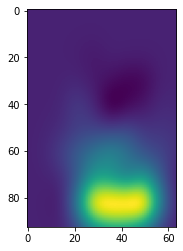

In [96]:
plt.imshow(field[15, :, :, 2])

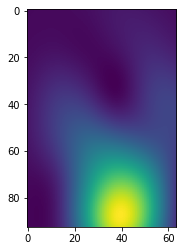

In [76]:
plt.imshow(field[15, :, :, 2])

In [98]:
# Write the meshes

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source model(rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = itk.meshread(movingMeshPath)
for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh_itk1.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
                         
for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

In [66]:
print(movingPS_np.shape)
print(fixedPS_np.shape)
print(movingPSNew_np.shape)

(6845, 3)
(5591, 3)
(6845, 3)


In [81]:
movingMesh_itk_np = itk.array_from_vector_container(movingMesh.GetPoints())
print(movingMesh_itk_np.shape)

(2351553, 3)


In [92]:
test1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.vtk')
test2 = readvtk('movingMesh_itk.vtk')
test3 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/TPS Warped source model_1.vtk')

itkwidgets.view(geometries=[test1, test2, test3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [72]:
movingPS_np = itk.array_from_vector_container(movingPS.GetPoints())
fixedPS_np = itk.array_from_vector_container(fixedPS.GetPoints())
movingPSNew_np = itk.array_from_vector_container(movingPSNew.GetPoints())

itkwidgets.view(point_sets=[movingPS_np, movingPSNew_np, fixedPS_np])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

(55, 94, 64, 3)


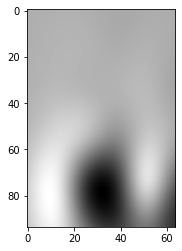

In [18]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [6]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(24, 48, 29, 3)


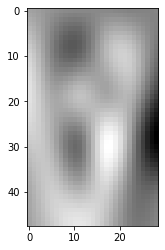

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [52]:

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape, movingMeshPoints.shape)

(8002, 3) (3754, 3)


In [98]:
# Checking Point to Plane ICP

import open3d as o3d
from open3d import geometry
from open3d import utility

source = geometry.PointCloud()
source.points = utility.Vector3dVector(itk_transformed_points)

target = geometry.PointCloud()
target.points = utility.Vector3dVector(fixedMeshPoints)

radius_normal = 5

target.estimate_normals(
    geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

trans_init = np.identity(4)
threshold = 10

convergence = o3d.pipelines.registration.TransformationEstimationPointToPlane()

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init, convergence,
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
#draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=6.731486e-01, inlier_rmse=4.562815e+00, and correspondence_set size of 2527
Access transformation to get result.
Transformation is:
[[  0.95502067   0.13828085  -0.26232407 -12.74522843]
 [ -0.11599785   0.98833485   0.09868494  14.89261294]
 [  0.27291026  -0.06381713   0.9599205   -9.09552887]
 [  0.           0.           0.           1.        ]]


In [103]:
sp = np.asarray(source_temp.points)
tp = np.asarray(target_temp.points)

print(sp.shape, tp.shape)

(3754, 3) (8002, 3)


In [107]:
ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

ps1.SetPoints(itk.vector_container_from_array(tp.flatten().astype('float32')))
ps2.SetPoints(itk.vector_container_from_array(sp.flatten().astype('float32')))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(ps2)
metric.SetFixedPointSet(ps1)
metric.Initialize()

print(metric.GetValue())

8.35966483323909


In [105]:
itkwidgets.view(point_sets=[sp, tp])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [102]:
source_temp = copy.deepcopy(source)
target_temp = copy.deepcopy(target)
source_temp.transform(reg_p2p.transformation)

PointCloud with 3754 points.

In [63]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [58]:
trans_init = np.identity(4)
print(trans_init)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
